# Notebook2 - Linear Regression

In this Notebook:
- Create a simple linear model
- Diagnostic model
- Produce the associated results/graphs

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

RANDOM_STATE = 42
data_path = "../notebooks/data/processed/aapl_calls_ml_dataset.csv"
df = pd.read_csv(data_path, parse_dates=["QUOTE_DATE", "EXPIRE_DATE"])

df.shape, df.head()

((477267, 18),
   QUOTE_DATE EXPIRE_DATE  DTE   T_years      S      K  moneyness  log_moneyness     C_IV  C_DELTA  C_GAMMA   C_VEGA  \
 0 2022-07-01  2022-07-08  7.0  0.027778  138.9   85.0   1.634118       0.491103  0.00048  1.00000  0.00000  0.15666   
 1 2022-07-01  2022-07-08  7.0  0.027778  138.9  100.0   1.389000       0.328584  0.00628  1.00000  0.00000  0.00000   
 2 2022-07-01  2022-07-08  7.0  0.027778  138.9  105.0   1.322857       0.279794  0.75157  0.99524  0.00082  0.00284   
 3 2022-07-01  2022-07-08  7.0  0.027778  138.9  115.0   1.207826       0.188822  0.00037  1.00000  0.00000  0.34662   
 4 2022-07-01  2022-07-08  7.0  0.027778  138.9  117.0   1.187179       0.171580  0.00093  1.00000  0.00000  0.35924   
 
    C_THETA    C_RHO  C_VOLUME  STRIKE_DISTANCE  STRIKE_DISTANCE_PCT  TARGET_PRICE  
 0  0.00000  0.00000       0.0             53.9                0.388        53.900  
 1 -0.00343  0.02150       0.0             38.9                0.280        38.925  
 2 -0.01

# 1st Regression on C/S:
- reduction of heteroscedasticity
- improved comparability between strikes
- more stable coefficients

In [3]:
target = df["TARGET_PRICE"]/df["S"].copy()   # Definition of the target variable
target.describe(), target.isna().sum()

(count    477267.000000
 mean          0.175704
 std           0.208020
 min           0.000027
 25%           0.007394
 50%           0.082500
 75%           0.292070
 max           0.868262
 dtype: float64,
 np.int64(0))

# ⚠️ Warning possible ‘leak’ with the Greeks -
C_DELTA, C_GAMMA, C_VEGA, etc. are often calculated based on price (or at least via IV + model).

If they were calculated based on S, K, T, r, IV without using TARGET_PRICE → that's OK.

As I don't know the exact calculation in the dataset, I suggest a safe approach.

In [4]:
features = [
    "log_moneyness",
    "T_years",
    "C_IV",
    "C_VOLUME",
]
features = [f for f in features if f in df.columns]

greeks = ["C_DELTA", "C_GAMMA", "C_VEGA", "C_THETA", "C_RHO"]
greeks = [g for g in greeks if g in df.columns]

# ‼️ Exploratory analysis & diagnosis prior to feature selection

Before defining the explanatory variables used in pricing models, it is necessary to analyse the data structure in order to:

- identify any redundancy of information,
- detect the risks of multicollinearity,
- adapt the choice of variables to the type of model used (linear vs. non-linear).

This step helps to avoid arbitrary choices and ensure the stability and interpretability of the models.



In [5]:
corr = df[features + ["TARGET_PRICE"]].corr()
corr            # Display the correlation matrix

,log_moneyness,T_years,C_IV,C_VOLUME,TARGET_PRICE
log_moneyness,1.000000,0.031258,0.378920,-0.030987,0.930950
T_years,0.031258,1.000000,-0.204450,-0.083941,0.229017
C_IV,0.378920,-0.204450,1.000000,-0.041920,0.390546
C_VOLUME,-0.030987,-0.083941,-0.041920,1.000000,-0.084302
TARGET_PRICE,0.930950,0.229017,0.390546,-0.084302,1.000000


👀 First observation :

moneyness and log_moneyness are directly constructed from S and K, therefore there is a structural dependence between these variables.

Logical correlation between TARGET_PRICE and moneyness, C_IV, T_year

C_Volume does not import any additional information into the model; we have chosen to remove it for the sake of simplicity.

In [6]:
features.remove("C_VOLUME")
features

['log_moneyness', 'T_years', 'C_IV']

# 🔗 Focus on Multicolinearity - VIF Diagnosis
-install statsmodels

- VIF ≈ 1–2 → Good
- VIF > 5 → important colinearity
- VIF > 10 → severe multicolinearity

In [7]:
X_vif = df[
    ["log_moneyness", "T_years", "C_IV"]
].dropna()

vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
})

vif_df


,feature,VIF
0,log_moneyness,1.149124
1,T_years,1.245539
2,C_IV,1.404435


# 🧮 Split Train / Test - 1st January 2023

In [8]:
df = df.sort_values("QUOTE_DATE").copy() # Sort by quote date for split (train/test)

split_date = pd.Timestamp("2023-01-01")

train_mask = df["QUOTE_DATE"] < split_date
test_mask  = df["QUOTE_DATE"] >= split_date

train_mask.mean(), test_mask.mean()   # proportion of train/test

(np.float64(0.8723188487785662), np.float64(0.1276811512214337))

In [9]:
X = df[features].copy()                    #  feature matrix (log_moneyness, T_years, C_IV, C_VOLUME)
y = (df["TARGET_PRICE"] / df["S"]).copy()  #  target C/S

X_train = X.loc[train_mask]
y_train = y.loc[train_mask]

X_test  = X.loc[test_mask]
y_test  = y.loc[test_mask]

## CHECKS:
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train dates:", df.loc[train_mask, "QUOTE_DATE"].min(), "->", df.loc[train_mask, "QUOTE_DATE"].max())
print("Test  dates:", df.loc[test_mask,  "QUOTE_DATE"].min(), "->", df.loc[test_mask,  "QUOTE_DATE"].max())

Train: (416329, 3)  Test: (60938, 3)
Train dates: 2021-01-04 00:00:00 -> 2022-12-30 00:00:00
Test  dates: 2023-01-03 00:00:00 -> 2023-03-31 00:00:00


The training set represents 87% of the observations, while the test set corresponds to the year 2023. This distribution is deliberately dictated by a time constraint in order to avoid any information leakage, and not by an arbitrary proportion (type 80/20).

## ⏹️ Standardisation -

In [10]:
scaler = StandardScaler()   # class : z-mu / sigma scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## 🏋️ Train linear regression -

In [11]:
# Fit linear regression model
lin_reg = LinearRegression()    # empty model
lin_reg.fit(X_train_scaled, y_train)    # train the model

# Predictions
y_pred_train = lin_reg.predict(X_train_scaled) # predictions on the train set
y_pred_test  = lin_reg.predict(X_test_scaled) # prediction on the test set

## 🤔 Evaluate -

In [12]:
def metrics(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE={mae:.6f} | RMSE={rmse:.6f} | R2={r2:.4f}")

metrics(y_train, y_pred_train, "TRAIN")
metrics(y_test,  y_pred_test,  "TEST ")


TRAIN MAE=0.042299 | RMSE=0.051731 | R2=0.9399
TEST  MAE=0.046830 | RMSE=0.058402 | R2=0.8973


- Performance doesn't collapse between training and testing (similar R2).
- No overfitting, order of magnitude good for RSME.
- MAE: on average, the price error is 4.6% of the spot price (Apple = $150 -> $7). For a simple linear regression, respectable.

## 🔢 Coefficient -

In [13]:
coef = pd.Series(lin_reg.coef_, index=X_train.columns).sort_values(key=np.abs, ascending=False)
intercept = lin_reg.intercept_

coef, intercept

(log_moneyness    0.188260
 T_years          0.046154
 C_IV             0.022952
 dtype: float64,
 np.float64(0.18103502581855138))

In [14]:
price_true = df.loc[test_mask, "TARGET_PRICE"].values
price_pred = y_pred_test * df.loc[test_mask, "S"].values

mae_price = mean_absolute_error(price_true, price_pred)
rmse_price = np.sqrt(mean_squared_error(price_true, price_pred))
mae_price, rmse_price

(6.870403619536535, np.float64(8.503023468629172))

## 📊 Plots - 

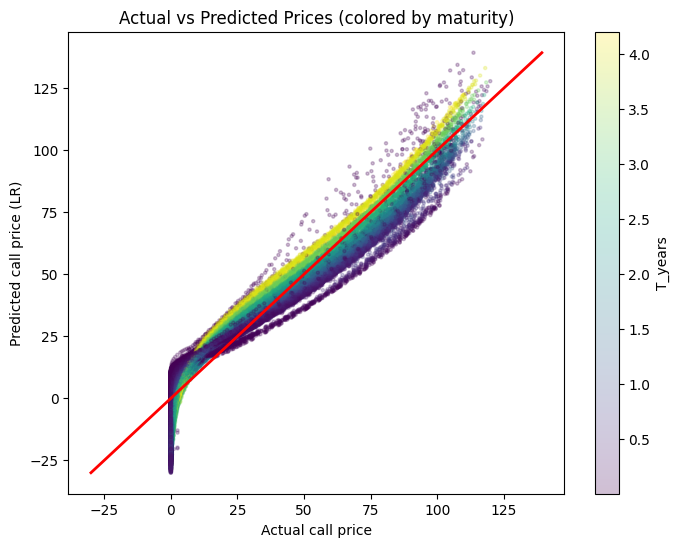

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(price_true, price_pred, c=X_test["T_years"], s=5, alpha=0.25)
lims = [min(price_true.min(), price_pred.min()), max(price_true.max(), price_pred.max())]
plt.plot(lims, lims, 'r-', linewidth=2)
plt.xlabel("Actual call price")
plt.ylabel("Predicted call price (LR)")
plt.title("Actual vs Predicted Prices (colored by maturity)")
plt.colorbar(label="T_years")
plt.show()

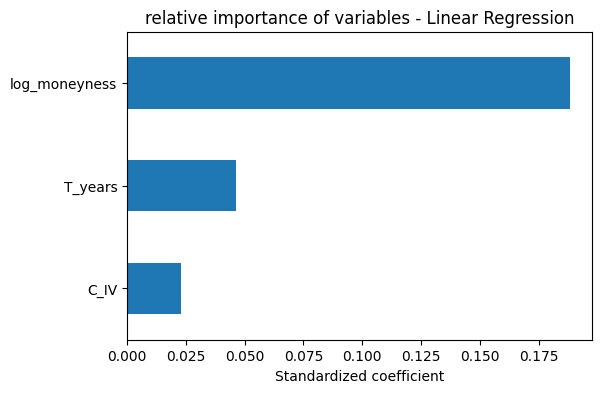

In [16]:
coef_sorted = coef.sort_values(key=np.abs)

plt.figure(figsize=(6,4))
coef_sorted.plot(kind="barh")
plt.title("relative importance of variables - Linear Regression")
plt.xlabel("Standardized coefficient")
plt.show()


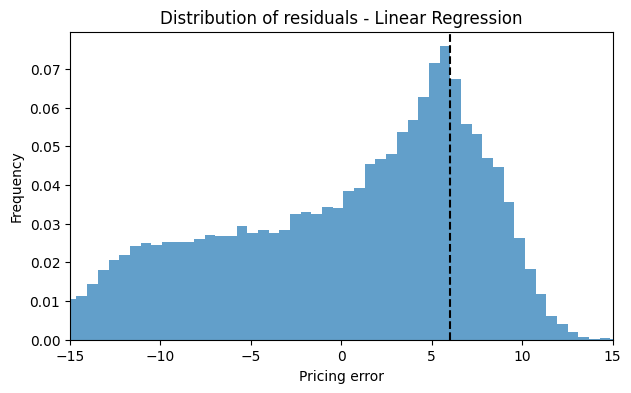

In [17]:
residuals = price_pred - price_true

plt.figure(figsize=(7,4))
plt.hist(residuals, bins=100, alpha=0.7, density=True)
plt.axvline(6, linestyle="--", color="black")
plt.xlim(-15, 15)
plt.xlabel("Pricing error")
plt.ylabel("Frequency")
plt.title("Distribution of residuals - Linear Regression")
plt.show()

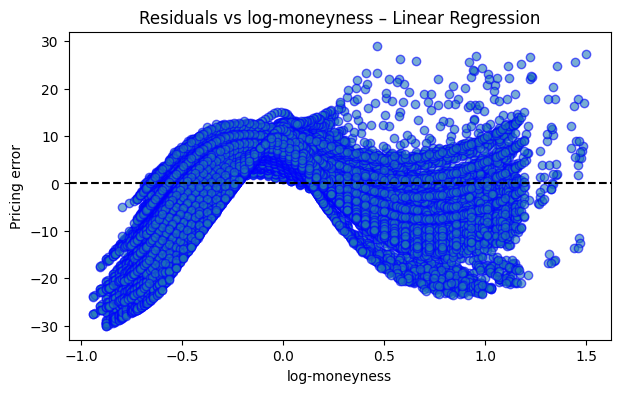

In [18]:
log_m = df.loc[test_mask, "log_moneyness"].values

plt.figure(figsize=(7,4))
plt.scatter(log_m, residuals, alpha=0.6, edgecolors="blue")
plt.axhline(0, linestyle="--", color="black")

plt.xlabel("log-moneyness")
plt.ylabel("Pricing error")
plt.title("Residuals vs log-moneyness – Linear Regression")
plt.show()

In [19]:
X_greeks = df.loc[test_mask, greeks].fillna(0)
y_res = residuals

aux_reg = LinearRegression()
aux_reg.fit(X_greeks, y_res)

print (pd.Series(aux_reg.coef_, index=greeks),"R2:", aux_reg.score(X_greeks, y_res))


C_DELTA      2.181374
C_GAMMA    353.187982
C_VEGA       0.000505
C_THETA    -26.865635
C_RHO        0.091599
dtype: float64 R2: 0.33095295131716795


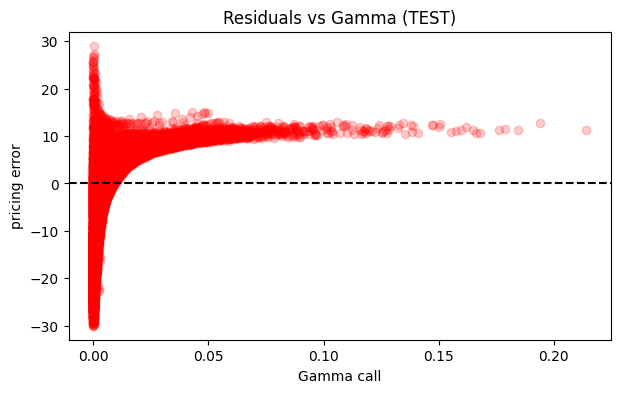

In [20]:
gamma = df.loc[test_mask, "C_GAMMA"].values

plt.figure(figsize=(7,4))
plt.scatter(gamma, residuals, alpha=0.2 , color="red")
plt.axhline(0, linestyle="--", color="black")

plt.xlabel("Gamma call")
plt.ylabel("pricing error")
plt.title("Residuals vs Gamma (TEST)")
plt.show()


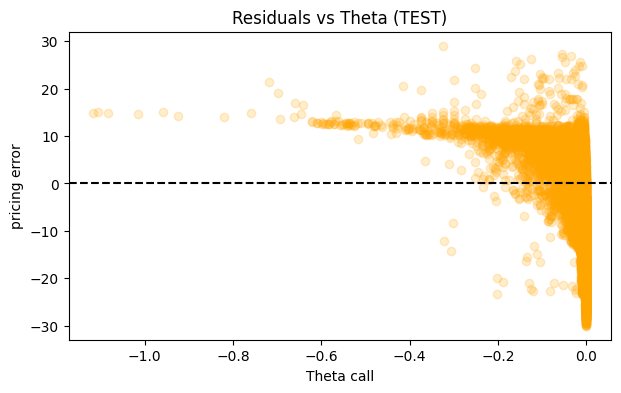

In [21]:
delta = df.loc[test_mask, "C_THETA"].values

plt.figure(figsize=(7,4))
plt.scatter(delta, residuals, alpha=0.2, color="orange")
plt.axhline(0, linestyle="--", color="black")

plt.xlabel("Theta call")
plt.ylabel("pricing error")
plt.title("Residuals vs Theta (TEST)")
plt.show()


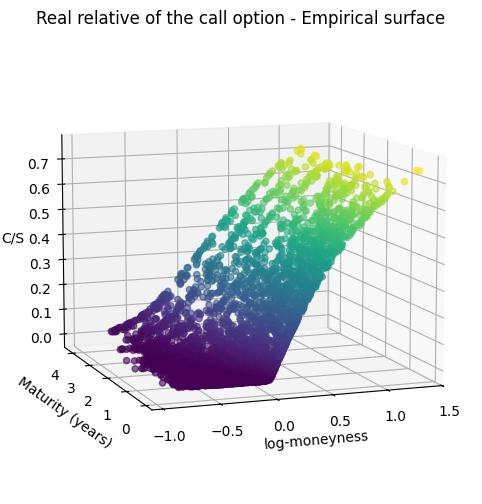

In [22]:
df_3d = df.loc[test_mask, [
    "log_moneyness", "T_years", "TARGET_PRICE", "S"
]].sample(5000, random_state=42)

df_3d["C/S"] = df_3d["TARGET_PRICE"] / df_3d["S"]

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection="3d")

sc=ax.scatter(
    df_3d["log_moneyness"],
    df_3d["T_years"],
    df_3d["C/S"],
    c=df_3d["C/S"],
    cmap="viridis",
    alpha=0.6,
)

ax.set_xlabel("log-moneyness")
ax.set_ylabel("Maturity (years)")
ax.set_zlabel("C/S")
ax.set_title("Real relative of the call option - Empirical surface")
ax.view_init(elev=10, azim=-110)


plt.show()
